<a href="https://colab.research.google.com/github/alexanderdrent/Uncertainty-Analysis-Windmaster/blob/master/python_src/Windmaster_SOBOL_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install ema_workbench and SALib
!pip install ema_workbench
!pip install SALib

     |████████████████████████████████| 23.7MB 165kB/s 
  Created wheel for ema-workbench: filename=ema_workbench-2.0.8-cp36-none-any.whl size=23772558 sha256=3a8458178f282540952238390ea308805dcad690d5cf85113081c68d238b1c97
  Stored in directory: /root/.cache/pip/wheels/62/ef/66/b32ebb75d741a7582de4a92dff6a0c9ffe84454919e8a12bfa
Successfully built ema-workbench
     |████████████████████████████████| 860kB 2.8MB/s 
  Created wheel for SALib: filename=SALib-1.3.11-py2.py3-none-any.whl size=729664 sha256=1cb80915936c85df269a3e97f4cbfedf8835cd607c9c6def38ffe77239b80765
  Stored in directory: /root/.cache/pip/wheels/62/ed/f9/a0b98754ffb2191b98324b96cbbeb1bd5d9598b39ab996b429
Successfully built SALib


In [ ]:
# load packages
import math
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime
import json

from matplotlib.path import Path
import matplotlib.patches as patches


from ema_workbench.util.utilities import load_results
from ema_workbench.analysis import (feature_scoring, plotting,
                                    pairs_plotting, get_ex_feature_scores)
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.analysis.plotting import kde_over_time, lines, multiple_densities
from ema_workbench.analysis.pairs_plotting import pairs_density, pairs_lines, pairs_scatter

from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ema_workbench/em_framework/evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
/usr/local/lib/python3.6/dist-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [ ]:
# Load results

results = load_results('../EPA/Master Thesis/Results/1000_SOBOL.tar.gz')
experiments, outcomes = results

In [ ]:
# construct two KPI's
outcomes['tennet_used_capacity'] = outcomes['tennet_load'] / outcomes['tennet_capacity'] * 100
outcomes['total_capex'] = outcomes['stedin capex'] + outcomes['tennet capex'] + outcomes['gasunie capex'] + outcomes['collaborative capex']

In [ ]:
# Calculate outcome means for the replications per experiment

outcomes_mean = {}
for outcome in ['stedin_capacity', 'stedin_load', 'tennet_capacity',
                'tennet_load', 'gasunie_capacity',
                'stedin capex', 'tennet capex', 'gasunie capex',
                'collaborative capex', 'h2_import', 'stedin_lost',
                'missed_over_time', 'first_failure', 'total_capex',
                'tennet_used_capacity']:
  outcomes_mean[outcome] = outcomes[outcome].mean(axis=1)

# Subdivide uncertainties (integers, categorical, boolean and real)

unc_int_years = ['timing CCS']

unc_int = ['random-seed']

unc_cat = ['BOILER paths', 'COGEN paths', 'FURNACE paths',
           'decisionMakingModel'
           ]
unc_bool = ['shuffle-needed-investments?', 'offshore wind growth',
            'yearHydrocrackerBP']

unc_real = ['capex_factor', 'leadtime_factor']

# Determine KPI's and construct dict 
# kpi_dict = {original_ parameter_name: [Long description (for titles), short name with unit (for y-axis), short name]}

kpi_dict = {'missed_over_time': ['Missed Transition Pathway Events', 'Missed Events (#)', 'Missed Events'],
            'investments': ['Realized Infrastructure Investments', 'Investments (#)', 'Investments'],
            'tennet_used_capacity': ['Used Capacity of TenneT\'s Infrastructure', 'Used Capacity (%)', 'Used Capacity TenneT'],
            'total_capex': ['Capital Expenditure of all Infrastructure Parties', 'CAPEX (\u20ac)', 'Total CAPEX']}

kpi_over_time = ['missed_over_time', 'tennet_used_capacity', 'total_capex']

# store KPIs in seperate dict 
outcomes_mean_kpi = {}
for kpi in kpi_over_time:
  outcomes_mean_kpi[kpi] = outcomes_mean[kpi]

# for the KPI's over time (missed over time, tennet used capacity, total capex) calculate the development over time and store in seperate dict
# for Missed over time and total capex: cumsum. Tennet used capacity remains the same. 
outcomes_mean_kpi_over_time = {}
outcomes_mean_kpi_over_time['missed_over_time'] = outcomes_mean['missed_over_time'].cumsum(axis=1)
outcomes_mean_kpi_over_time['tennet_used_capacity'] = outcomes_mean['tennet_used_capacity']
outcomes_mean_kpi_over_time['total_capex'] = outcomes_mean['total_capex'].cumsum(axis=1)

# store KPI's in long form dataframe for line plotting
outcomes_mean_kpi_longform = {}
outcomes_mean_kpi_over_time_longform = {}
for kpi in kpi_over_time:
  outcomes_mean_kpi_longform[kpi] = pd.DataFrame(outcomes_mean_kpi[kpi])
  outcomes_mean_kpi_longform[kpi]['decisionMakingModel'] = experiments.decisionMakingModel
  outcomes_mean_kpi_longform[kpi]['experiment'] = experiments.index.values
  outcomes_mean_kpi_longform[kpi] = pd.melt(frame = outcomes_mean_kpi_longform[kpi],
                                            id_vars=['decisionMakingModel', 'experiment'],
                                            value_vars=np.arange(0, outcomes_mean_kpi[kpi].shape[1]),
                                            var_name='year',
                                            value_name=kpi)
  outcomes_mean_kpi_longform[kpi].year += 2020
  outcomes_mean_kpi_over_time_longform[kpi] = pd.DataFrame(outcomes_mean_kpi_over_time[kpi])
  outcomes_mean_kpi_over_time_longform[kpi]['decisionMakingModel'] = experiments.decisionMakingModel
  outcomes_mean_kpi_over_time_longform[kpi]['experiment'] = experiments.index.values
  outcomes_mean_kpi_over_time_longform[kpi] = pd.melt(frame = outcomes_mean_kpi_over_time_longform[kpi],
                                                      id_vars=['decisionMakingModel', 'experiment'],
                                                      value_vars=np.arange(0, outcomes_mean_kpi_over_time[kpi].shape[1]),
                                                      var_name='year',
                                                      value_name=kpi)
  outcomes_mean_kpi_over_time_longform[kpi].year += 2020

investment_id = pd.read_csv('../EPA/Master Thesis/Results/investIDwindmaster.csv')['InvestID'].values

investments = {}
investments_over_time = {}
investments_longform = {}
investments_over_time_longform = {}
investments_over_time_longform_furn = {}
investment_cats = ['GTS_grids', 'New_H2_grids', '380kVs', '150kVs', 'Others']
for cat in investment_cats:
  investments[cat] = []

for tick in range(30):
    investments_per_experiment = pd.DataFrame(np.mean(outcomes[f'investments_tick_{tick}'], axis=1),
                                              columns=investment_id)
    investments_per_experiment['GTS_grids'] = investments_per_experiment[['GTSgrid1H2',	'GTSgrid2H2',	'GTSgrid3H2',	'GTSgrid3proactH2']].sum(axis=1)
    investments_per_experiment['New_H2_grids'] = investments_per_experiment[['NewH2grid1a', 'NewH2grid1b', 'NewH2grid1c', 'NewH2grid1d', 'NewH2grid2', 'NewH2grid3']].sum(axis=1)
    investments_per_experiment['380kVs'] = investments_per_experiment[['380kVbayTenneT_gen', '380kVbayTenneT_line', '380kVbayTenneT_trans', '380kVbayTenneT_cust', '380kV_station', '380kVgrid1', '380kVgrid2', '380kVgrid3', '380kVgrid4']].sum(axis=1)
    investments_per_experiment['150kVs'] = investments_per_experiment[['150kVbayTenneT_gen', '150kVbayTenneT_line', '150kVbayTenneT_trans', '150kVbayTenneT_cust', '150kV_station', '150kVgrid4', '150kVgrid5', '150kVgrid6', '150kVgrid7', '150kVgrid8', '150kVgrid9', '150kVgrid10']].sum(axis=1)
    investments_per_experiment['Others'] = investments_per_experiment[['Station_Stedin_extension', 'SwitchStedinTenneT','SwitchTennet150TenneT380']].sum(axis=1)

    for cat in investment_cats:
      investments[cat].append(investments_per_experiment[cat])

for cat in investment_cats:
    investments[cat] = pd.concat(investments[cat], axis=1, sort=False)
    investments[cat].columns = np.arange(2020, 2050, 1)

    investments_over_time[cat] = investments[cat].cumsum(axis=1)
    investments_over_time[cat].columns = np.arange(2020, 2050, 1)

    investments_longform[cat] = pd.DataFrame(investments[cat])
    investments_longform[cat]['decisionMakingModel'] = experiments.decisionMakingModel
    investments_longform[cat]['experiment'] = experiments.index.values
    investments_longform[cat] = pd.melt(frame = investments_longform[cat],
                                              id_vars=['decisionMakingModel', 'experiment'],
                                              var_name='year',
                                              value_name=cat)
    investments_over_time_longform[cat] = pd.DataFrame(investments_over_time[cat], copy=True)
    investments_over_time_longform[cat]['decisionMakingModel'] = experiments.decisionMakingModel
    investments_over_time_longform[cat]['experiment'] = experiments.index.values
    investments_over_time_longform[cat] = pd.melt(frame = investments_over_time_longform[cat],
                                              id_vars=['decisionMakingModel', 'experiment'],
                                              var_name='year',
                                              value_name=cat)
    
    investments_over_time_longform_furn[cat] = pd.DataFrame(investments_over_time[cat], copy=True)
    investments_over_time_longform_furn[cat]['FURNACE paths'] = experiments['FURNACE paths']
    investments_over_time_longform_furn[cat]['experiment'] = experiments.index.values
    investments_over_time_longform_furn[cat] = pd.melt(frame = investments_over_time_longform_furn[cat],
                                              id_vars=['FURNACE paths', 'experiment'],
                                              var_name='year',
                                              value_name=cat)

problem = {'num_vars': 10,
            'names': ['BOILER paths',
                      'COGEN paths',
                      'FURNACE paths',
                      'capex_factor',
                      'decisionMakingModel',
                      'leadtime_factor',
                      'offshore wind growth',
                      'random-seed',
                      'shuffle-needed-investments?',
                      'timing CCS'],
            'bounds': [(0, 5),
                        (0, 4),
                        (0, 5),
                        (0.7, 1.3),
                        (0, 4),
                        (0.7, 1.3),
                        (0, 2),
                        (-2147483648, 2147483648),
                        (0, 2),
                        (2022, 2031)]
            }

In [ ]:
# set general figure aesthetics 
cmap = 'gist_heat'
cmap_r = 'gist_heat_r'
sns.set_context("paper")
sns.set_style("ticks", {'image.cmap': cmap})
color = "#9B2D1F"
colors = ['#9B2D1F', '#fc8d59', '#d7301f']
palette = "OrRd"
sns.set_palette('rocket')

In [ ]:
def save_fig(fig, name,dir='../EPA/Master Thesis/Results/Figures/SOBOL',dpi=300):
    fig.savefig('{}/fig_{}_{}dpi.png'.format(dir, name, dpi), dpi=dpi, 
                bbox_inches='tight', format='png')

In [ ]:
data=experiments[unc_int + unc_int_years + unc_real]

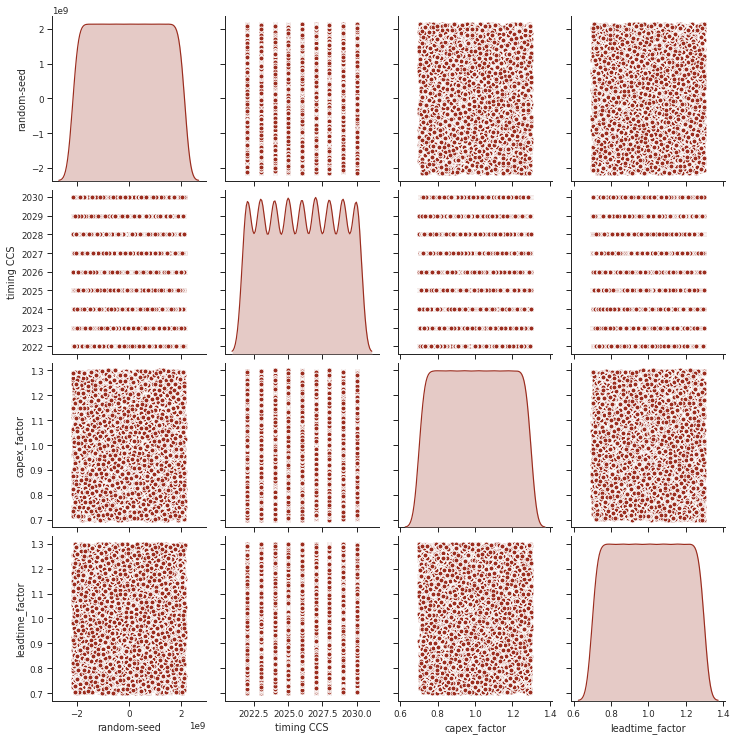

In [ ]:
pairgrid = sns.pairplot(data,
                        kind= 'scatter',
                        diag_kind="kde",
                        plot_kws={'color':color},
                        diag_kws={'shade':True, 'color':color})
plt.show()

save_fig(pairgrid.fig, name='pairplot_experiments')

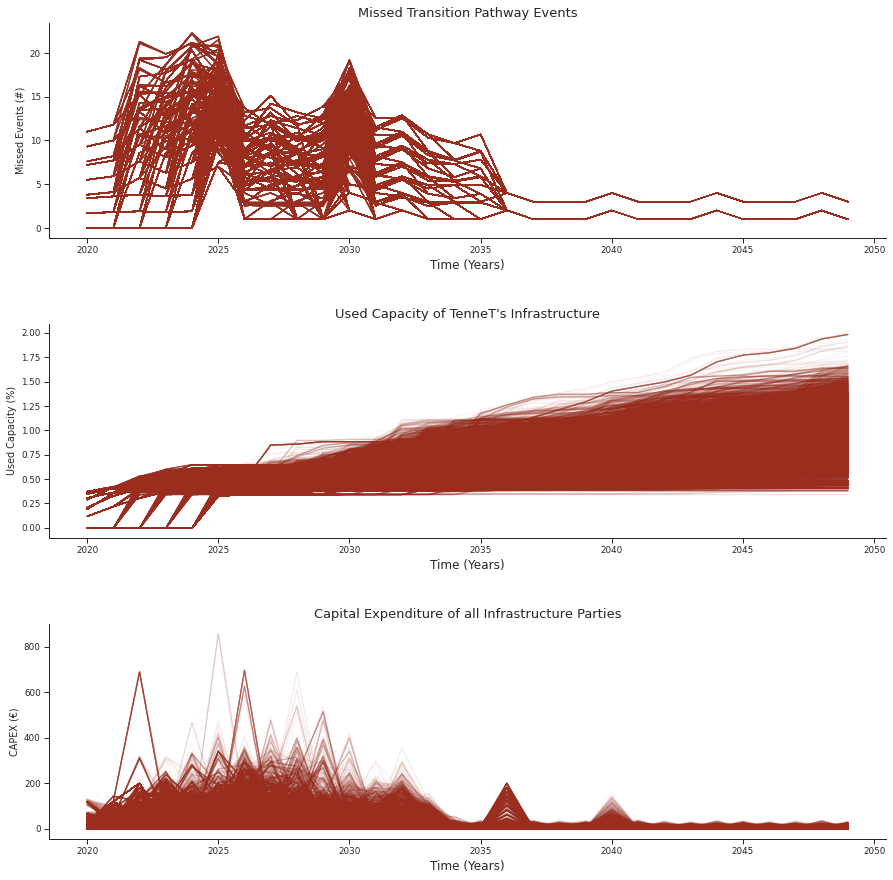

In [ ]:
fig, axes = lines(experiments = experiments,
                  outcomes = outcomes_mean_kpi)
for ax in kpi_over_time:
  axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()+2020, dtype=int))
  axes[ax].set_ylabel(kpi_dict[ax][1])
  axes[ax].set_xlabel("Time (Years)", size=12)
  axes[ax].set_title(kpi_dict[ax][0], size=13)
  for line in axes[ax].get_lines():
      line.set_alpha(0.05)
      line.set_color(color)
fig.set_size_inches (15,15)
sns.despine()
plt.show()

save_fig(fig, name='lineplots_KPI')

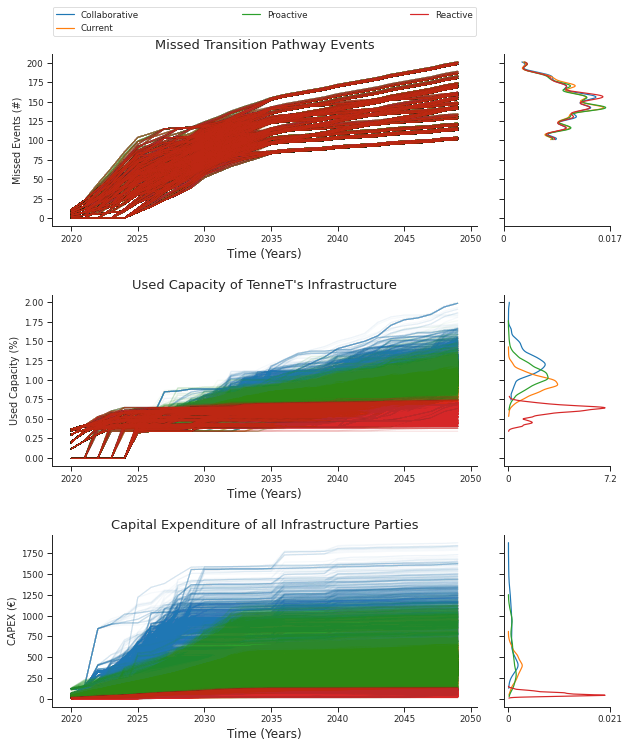

In [ ]:
fig, axes = lines(experiments, outcomes_mean_kpi_over_time, 
                group_by='decisionMakingModel', density=plotting.Density.KDE)
fig.set_size_inches(10,12)
for ax in kpi_over_time:
  axes[ax].set_xticklabels(np.array(axes[ax].get_xticks()+2020, dtype=int))
  axes[ax].set_ylabel(kpi_dict[ax][1])
  axes[ax].set_xlabel("Time (Years)", size=12)
  axes[ax].set_title(kpi_dict[ax][0], size=13)
  for line in axes[ax].get_lines():
    line.set_alpha(0.04)
sns.despine()
plt.show()

save_fig(fig, name='cumulative KPIs over time with KDE per DM')

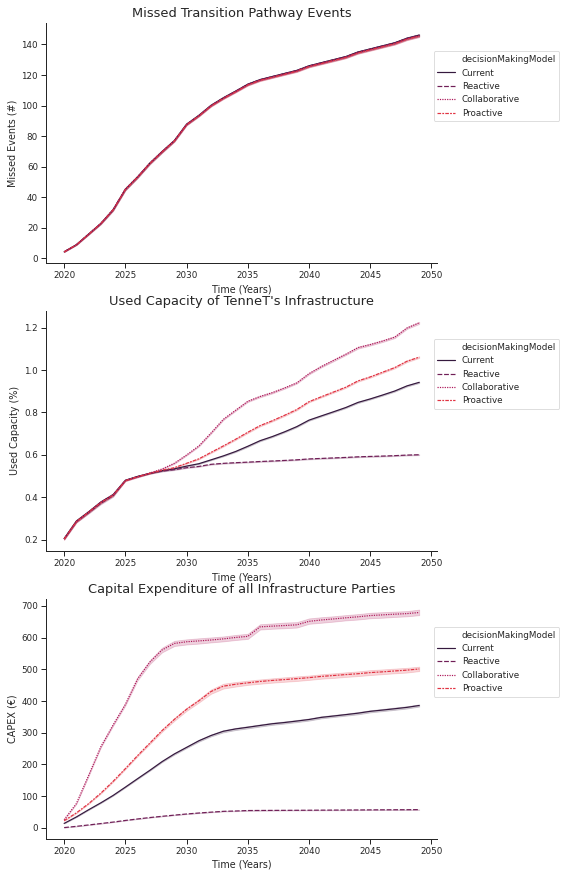

In [ ]:
fig, axes = plt.subplots(3, figsize=(7, 15))
for ax, kpi in enumerate(kpi_over_time):
  axes[ax] = sns.lineplot(data = outcomes_mean_kpi_over_time_longform[kpi],
                    x = 'year',
                    y=kpi,
                    hue='decisionMakingModel',
                    style='decisionMakingModel',
                    ax=axes[ax])
  axes[ax].set_title(kpi_dict[kpi][0], size=13)
  axes[ax].set_xlabel("Time (Years)")
  axes[ax].set_ylabel(kpi_dict[kpi][1])
  axes[ax].legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False)
  sns.despine()

plt.show()
save_fig(fig, name='lineplots_cumulative_KPI_grouped_by_DM')

In [ ]:
scores_mean_kpi_over_time = feature_scoring.get_feature_scores_all(experiments, outcomes_mean_kpi_over_time)

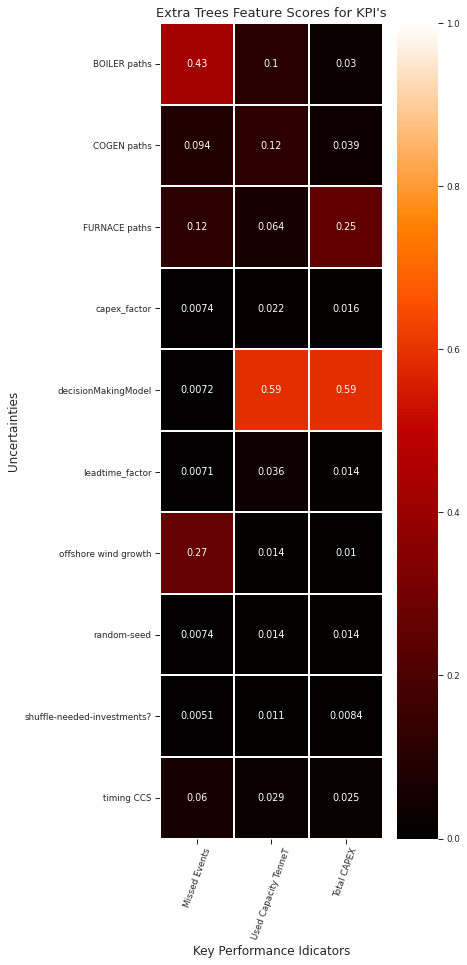

In [ ]:
fig, ax = plt.subplots(figsize=(5, 15))
ax = sns.heatmap(scores_mean_kpi_over_time, annot=True,
                 cmap = cmap,
                 vmin = 0, vmax = 1,
                 xticklabels = [kpi_dict[ooi][2] for ooi in scores_mean_kpi_over_time.columns],
                 yticklabels = 1,
                 linewidths=1)
ax.tick_params('x', labelrotation=70)
ax.set_title("Extra Trees Feature Scores for KPI's", size=13)
ax.set_xlabel("Key Performance Idicators", size = 12)
ax.set_ylabel("Uncertainties", size=12)
plt.show()

# save_fig(fig, name='Feature Scores for (cumulative) KPIs')

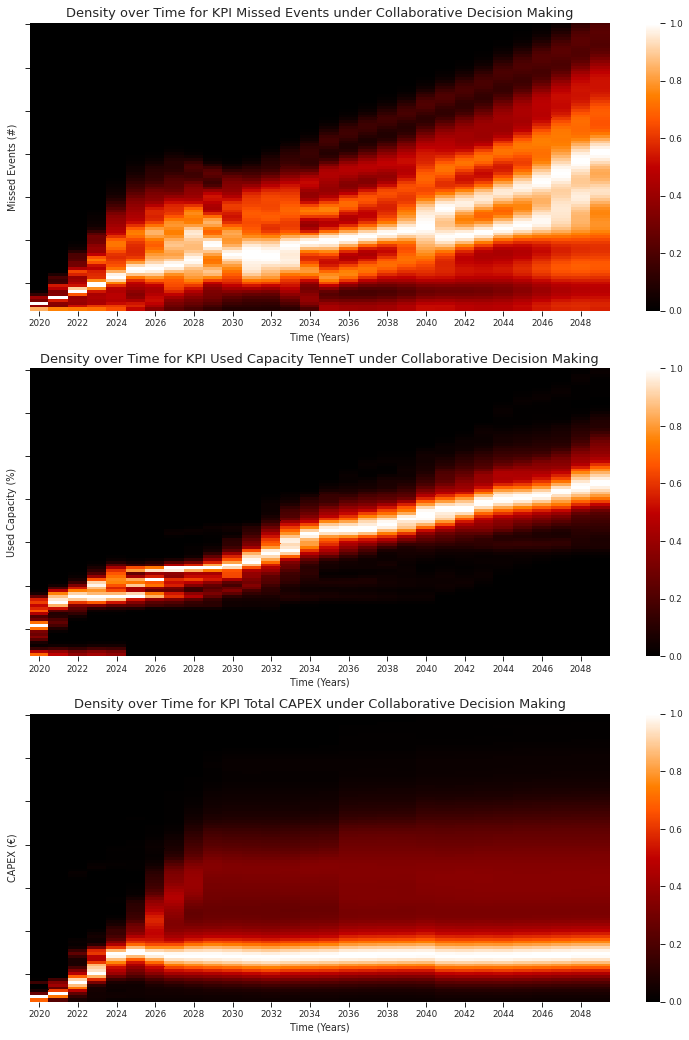

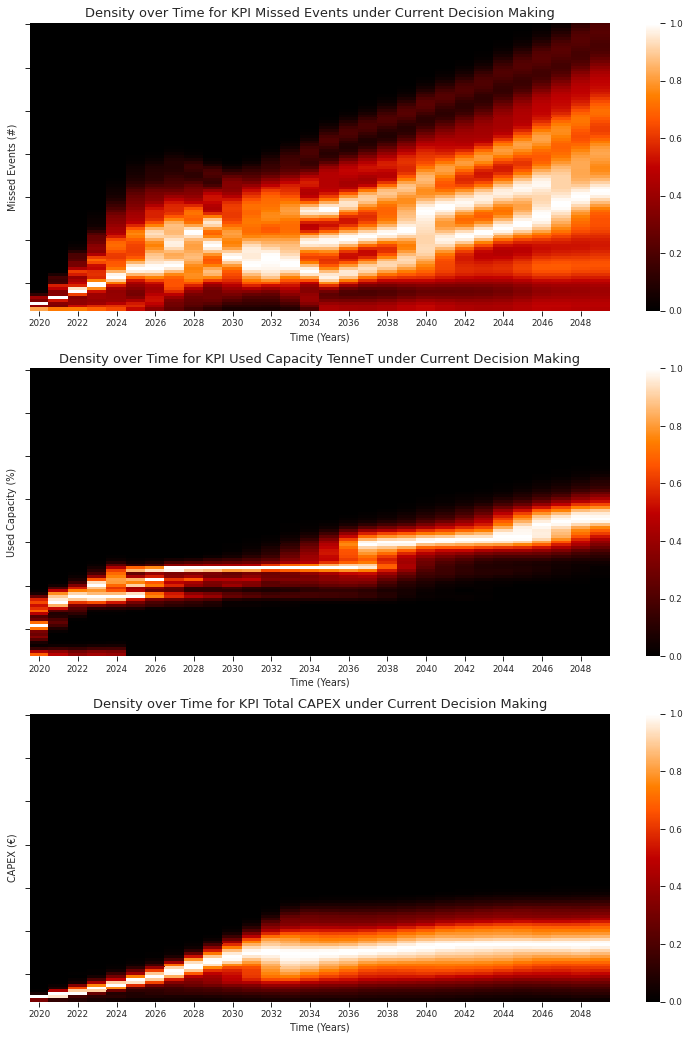

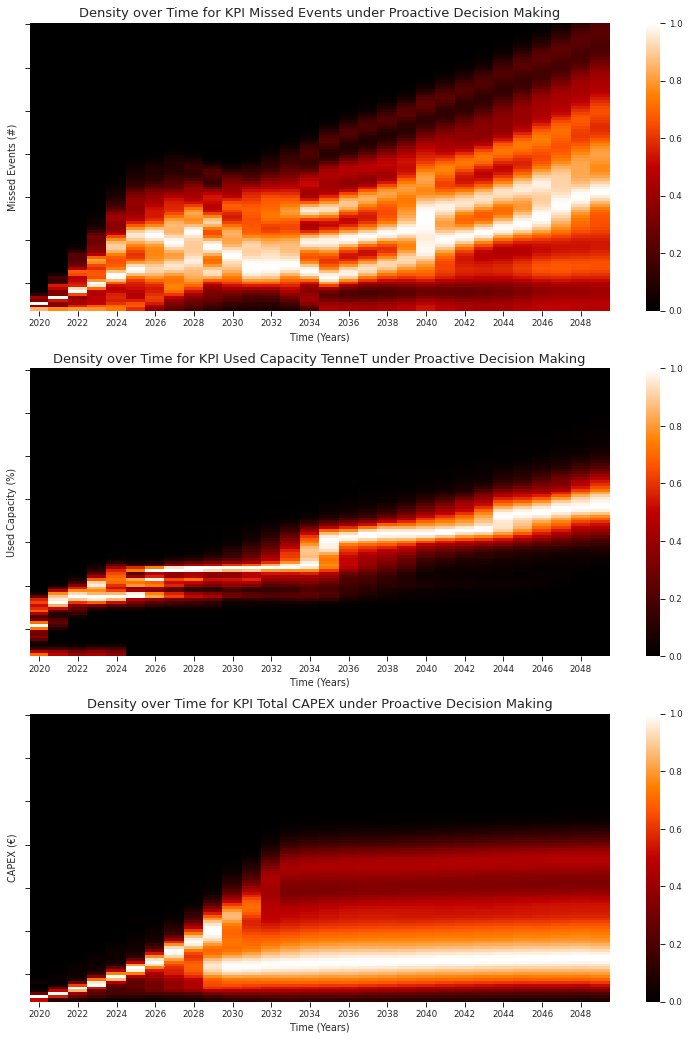

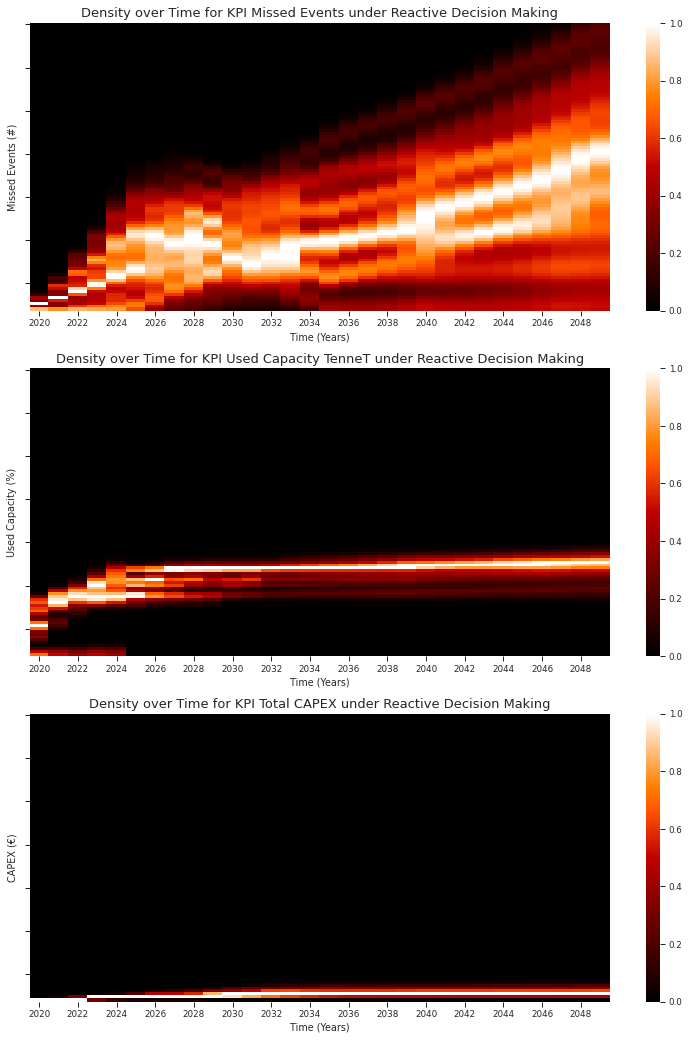

In [ ]:
# outcomes_to_show = ['tennet_used_capacity', 'total_capex']
figs, axes = kde_over_time(experiments,
                          outcomes_mean_kpi_over_time,
                          # outcomes_to_show = outcomes_to_show,
                          colormap=cmap,
                          group_by='decisionMakingModel',
                          log=False)
for fignr, dm in enumerate(axes.keys()):
  figs[fignr].set_size_inches(13,18)
  figs[fignr].suptitle(t=None)
  for ax in kpi_over_time:#outcomes_to_show:
    axes[dm][ax].set_xticklabels(np.array(axes[dm][ax].get_xticks()+2020, dtype=int))
    #axes[dm][ax].set_yticklabels(axes[dm][ax].get_yticks())
    #axes[dm]['tennet_used_capacity'].set_yticklabels(np.round(np.array(np.arange(0, 100, 5) / 100 * np.max(outcomes_mean_kpi_over_time['tennet_used_capacity']), dtype=float)[::-1],1))
    #axes[dm]['total_capex'].set_yticklabels(np.round(np.array(np.arange(0, 100, 5) / 100 * outcomes_mean_kpi_over_time['total_capex'].max(), dtype=float)[::-1],0))
    axes[dm][ax].set_ylabel(kpi_dict[ax][1])
    axes[dm][ax].set_xlabel("Time (Years)")
    axes[dm][ax].set_title(f"Density over Time for KPI {kpi_dict[ax][2]} under {dm} Decision Making", size=13)

  save_fig(figs[fignr], name=f'Density over Time for KPIs under {dm} DM')
    
plt.show()

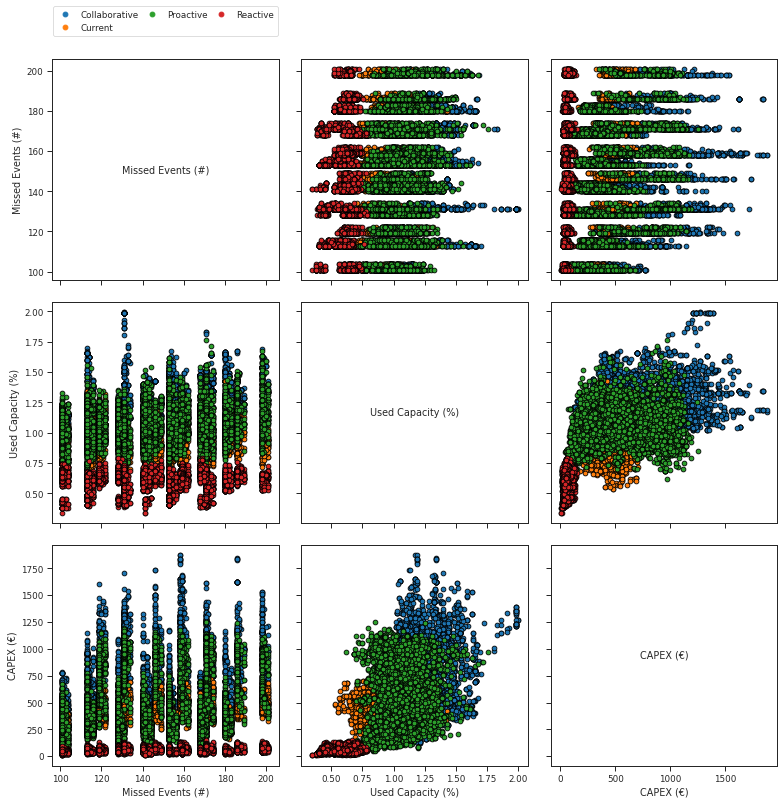

In [ ]:
fig, axes = pairs_scatter(experiments = experiments,
              outcomes = outcomes_mean_kpi_over_time,
              ylabels = {ooi: kpi_dict[ooi][1] for ooi in kpi_dict.keys()},
              group_by = 'decisionMakingModel',
              legend=True)
fig.set_size_inches (13,13)

plt.show()

save_fig(fig, name='pairs_scatter for KPIs')

In [ ]:
def get_st_scores_for_ooi (ooi):
    y = outcomes_mean_kpi_over_time[ooi]
    all_sts = []
    for year in range(y.shape[1]):
      st = sobol.analyze(problem, y[:,year])['ST']
      all_sts.append(st)
    all_sts = pd.DataFrame(all_sts).T
    all_sts.columns = np.arange(2020, 2050, 1)
    return all_sts

def plot_heatmap_overtime (scores, ooi, annot):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax = sns.heatmap(scores, cmap=cmap, vmin = 0, vmax = 1, annot = annot)
    ax.set_title('Total-Order Sobol Index over Time for KPI ' +kpi_dict[ooi][2], size = 13)
    ax.set_xlabel("Time (Years)", size=12)
    ax.set_ylabel("Uncertainties", size=12)
    ax.set_yticklabels(problem['names'], ** {'rotation': 0})
    plt.show()    
    save_fig(fig, name=f'Total-Order SI over time for {ooi}')

def plot_heatmap_overtime_for_variable(ooi, annot=False):
    all_sts = get_st_scores_for_ooi(ooi)
    plot_heatmap_overtime(all_sts, ooi, annot)

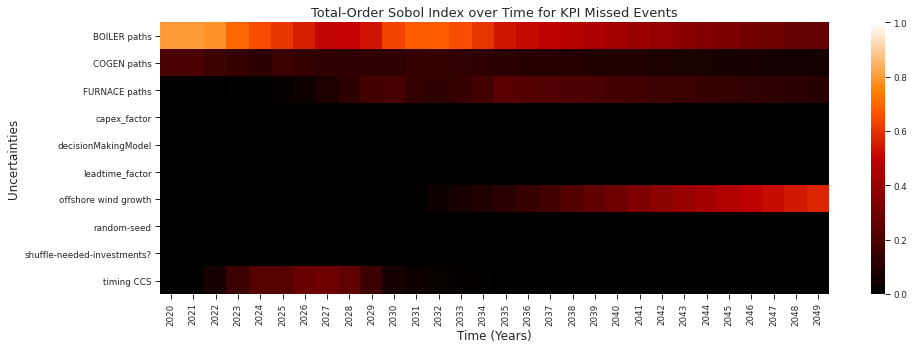

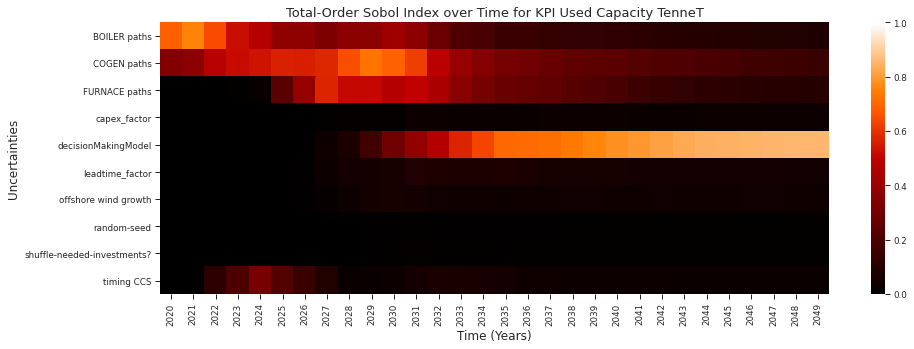

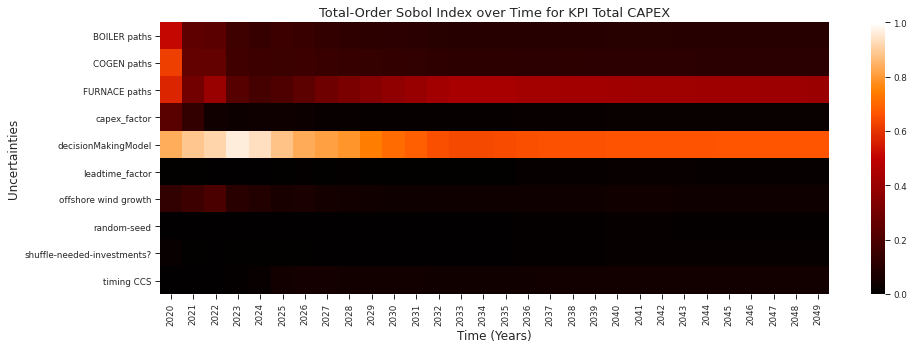

In [ ]:
for ooi in kpi_over_time:
    plot_heatmap_overtime_for_variable(ooi)
    

In [ ]:
y = outcomes_mean_kpi_over_time[ooi]

In [ ]:
y.shape[1]

30

In [ ]:
def get_sobol_scores(ooi):
    '''analyze results using SALib sobol, returns a dataframe
    '''
    y = outcomes_mean_kpi_over_time[ooi][:,-1]
    sobol_indices = sobol.analyze(problem, y)
    sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])
    sobol_stats.sort_values(by='ST', ascending=False)
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2_conf = pd.DataFrame(sobol_indices['S2_conf'], index=problem['names'],
                           columns=problem['names'])

    return sobol_stats, s2, s2_conf

In [ ]:
def get_max_si_s2():
  s2_max_all_ooi = []
  si_max_all_ooi = []
  for ooi in kpi_over_time:
    sobol_stats, s2, s2_conf = get_sobol_scores(ooi)
    s2_max_all_ooi.append(s2.max().max())
    si_max_all_ooi.append(sobol_stats.max().max())
  return np.max(si_max_all_ooi), np.max(s2_max_all_ooi)

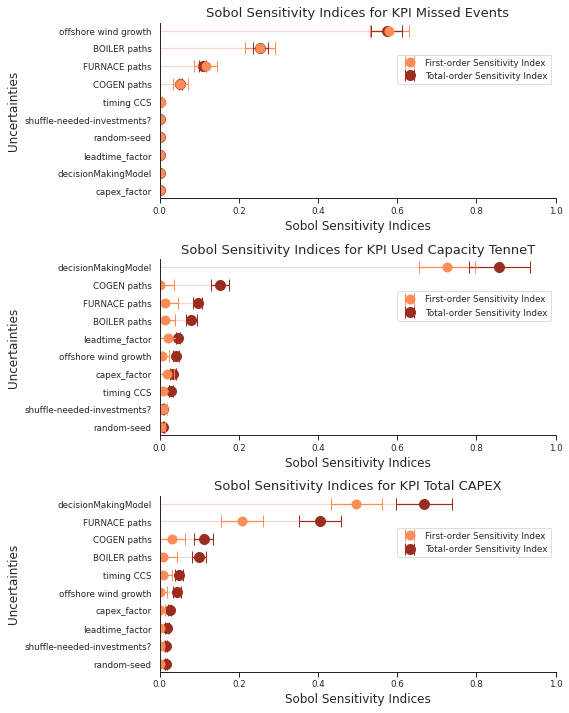

In [ ]:
with sns.axes_style("ticks", {"ytick.left": False}):
  fig, axes = plt.subplots(3,1, figsize=(8,10), sharex=False)
for axnr, ooi in enumerate(kpi_over_time):
  sobol_stats, _, _ = get_sobol_scores(ooi)
  sobol_stats = sobol_stats.sort_values(by='ST', ascending=True)
  sobol_stats[sobol_stats<0]=0

  height=range(1,len(sobol_stats.index)+1)
  axes[axnr].hlines(y=height, xmin=0, xmax=sobol_stats['ST'],
                     color=colors[2], alpha=0.2)
  axes[axnr].errorbar(x=sobol_stats['S1'],
                      y = height,
                      xerr = sobol_stats['S1_conf'],
                      color=colors[1],
                      alpha=1, label='First-order Sensitivity Index', fmt='o',
                      ms=9,
                      capsize = 6)
  axes[axnr].errorbar(x=sobol_stats['ST'],
                      y = height,
                      xerr = sobol_stats['ST_conf'],
                      color=colors[0],
                      alpha=1, label='Total-order Sensitivity Index', fmt='o',
                      barsabove = True,
                      ms=10,
                      capsize = 6)
  axes[axnr].legend(loc=(0.6,0.65))
  axes[axnr].set_yticks(height)
  axes[axnr].set_yticklabels(sobol_stats.index)
  axes[axnr].set_xlim(0,1)
  axes[axnr].set_xlabel("Sobol Sensitivity Indices", size=12)
  axes[axnr].set_ylabel("Uncertainties", size=12)
  axes[axnr].set_title(f"Sobol Sensitivity Indices for KPI {kpi_dict[ooi][2]}",
                       size=13)
fig.tight_layout()
sns.despine()
plt.show()
save_fig(fig, name='total_first_order sobol sensitivity indices')

In [ ]:
LW = 0.3

def polar2xy(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)])

def hex2rgb(c):
    return tuple(int(c[i:i+2], 16)/256.0 for i in (1, 3 ,5))

def IdeogramArc(start=0, end=60, radius=1.0, width=0.2, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start > end:
        start, end = end, start
    start *= np.pi/180.
    end *= np.pi/180.
    # optimal distance to the control points
    # https://stackoverflow.com/questions/1734745/how-to-create-circle-with-b%C3%A9zier-curves
    opt = 4./3. * np.tan((end-start)/ 4.) * radius
    inner = radius*(1-width)
    verts = [
        polar2xy(radius, start),
        polar2xy(radius, start) + polar2xy(opt, start+0.5*np.pi),
        polar2xy(radius, end) + polar2xy(opt, end-0.5*np.pi),
        polar2xy(radius, end),
        polar2xy(inner, end),
        polar2xy(inner, end) + polar2xy(opt*(1-width), end-0.5*np.pi),
        polar2xy(inner, start) + polar2xy(opt*(1-width), start+0.5*np.pi),
        polar2xy(inner, start),
        polar2xy(radius, start),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.LINETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CLOSEPOLY,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)


def ChordArc(start1=0, end1=60, start2=180, end2=240, radius=1.0, chordwidth=0.7, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start1 > end1:
        start1, end1 = end1, start1
    if start2 > end2:
        start2, end2 = end2, start2
    start1 *= np.pi/180.
    end1 *= np.pi/180.
    start2 *= np.pi/180.
    end2 *= np.pi/180.
    opt1 = 4./3. * np.tan((end1-start1)/ 4.) * radius
    opt2 = 4./3. * np.tan((end2-start2)/ 4.) * radius
    rchord = radius * (1-chordwidth)
    verts = [
        polar2xy(radius, start1),
        polar2xy(radius, start1) + polar2xy(opt1, start1+0.5*np.pi),
        polar2xy(radius, end1) + polar2xy(opt1, end1-0.5*np.pi),
        polar2xy(radius, end1),
        polar2xy(rchord, end1),
        polar2xy(rchord, start2),
        polar2xy(radius, start2),
        polar2xy(radius, start2) + polar2xy(opt2, start2+0.5*np.pi),
        polar2xy(radius, end2) + polar2xy(opt2, end2-0.5*np.pi),
        polar2xy(radius, end2),
        polar2xy(rchord, end2),
        polar2xy(rchord, start1),
        polar2xy(radius, start1),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)

def selfChordArc(start=0, end=360, radius=1.0, chordwidth=0.7, ax=None, color=(1,0,0)):
    # start, end should be in [0, 360)
    if start > end:
        start, end = end, start
    start *= np.pi/180.
    end *= np.pi/180.
    opt = 4./3. * np.tan((end-start)/ 4.) * radius
    rchord = radius * (1-chordwidth)
    verts = [
        polar2xy(radius, start),
        polar2xy(radius, start) + polar2xy(opt, start+0.5*np.pi),
        polar2xy(radius, end) + polar2xy(opt, end-0.5*np.pi),
        polar2xy(radius, end),
        polar2xy(rchord, end),
        polar2xy(rchord, start),
        polar2xy(radius, start),
        ]

    codes = [Path.MOVETO,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             Path.CURVE4,
             ]

    if ax == None:
        return verts, codes
    else:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color+(0.5,), edgecolor=color+(0.4,), lw=LW)
        ax.add_patch(patch)

def chordDiagram(X, ax, colors=None, width=0.1, pad=1, chordwidth=1):
    """Plot a chord diagram
    Parameters
    ----------
    X :
        flux data, X[i, j] is the flux from i to j
    ax :
        matplotlib `axes` to show the plot
    colors : optional
        user defined colors in rgb format. Use function hex2rgb() to convert hex color to rgb color. Default: d3.js category10
    width : optional
        width/thickness of the ideogram arc
    pad : optional
        gap pad between two neighboring ideogram arcs, unit: degree, default: 2 degree
    chordwidth : optional
        position of the control points for the chords, controlling the shape of the chords
    """
    # X[i, j]:  i -> j
    x = X.sum(axis = 1) # sum over rows
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

    if colors is None:
    # use d3.js category10 https://github.com/d3/d3-3.x-api-reference/blob/master/Ordinal-Scales.md#category10
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        if len(x) > 10:
            print('x is too large! Use x smaller than 10')
        colors = [hex2rgb(colors[i]) for i in range(len(x))]

    # find position for each start and end
    y = x/np.sum(x).astype(float) * (360 - pad*len(x))

    pos = {}
    arc = []
    nodePos = []
    start = 0
    for i in range(len(x)):
        end = start + y[i]
        arc.append((start, end))
        angle = 0.5*(start+end)
        print(start, end, angle)
        if -30 <= angle <= 210:
            angle -= 90
        else:
            angle -= 270
        nodePos.append(tuple(polar2xy(1.1, 0.5*(start+end)*np.pi/180.)) + (angle,))
        z = (X[i, :]/x[i].astype(float)) * (end - start)
        ids = np.argsort(z)
        z0 = start
        for j in ids:
            pos[(i, j)] = (z0, z0+z[j])
            z0 += z[j]
        start = end + pad

    for i in range(len(x)):
        start, end = arc[i]
        IdeogramArc(start=start, end=end, radius=1.0, ax=ax, color=colors[i], width=width)
        start, end = pos[(i,i)]
        selfChordArc(start, end, radius=1.-width, color=colors[i], chordwidth=chordwidth*0.7, ax=ax)
        for j in range(i):
            color = colors[i]
            if X[i, j] > X[j, i]:
                color = colors[j]
            start1, end1 = pos[(i,j)]
            start2, end2 = pos[(j,i)]
            ChordArc(start1, end1, start2, end2,
                     radius=1.-width, color=colors[i], chordwidth=chordwidth, ax=ax)

    #print(nodePos)
    return nodePos

##################################

0 76.32337031031587 38.16168515515793
79.32337031031587 97.65770909752194 88.4905397039189
100.65770909752194 146.88593194224967 123.77182051988581
149.88593194224967 152.70447427789082 151.29520311007025
155.70447427789082 158.52301661353198 157.1137454457114
161.52301661353198 164.34155894917313 162.93228778135256
167.34155894917313 333.2112325319262 250.27639574054967
336.2112325319262 341.0105477773461 338.6108901546362
344.0105477773461 348.809863022766 346.41020540005604
351.809863022766 356.99999999999994 354.404931511383


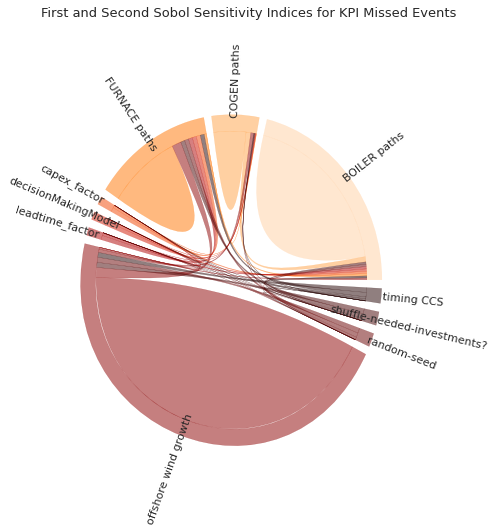

0 16.567533194106964 8.283766597053482
19.567533194106964 52.262704258655425 35.915118726381195
55.262704258655425 72.4086444239156 63.83567434128551
75.4086444239156 91.35066806045164 83.37965624218361
94.35066806045164 273.4903454546919 183.9205067575718
276.4903454546919 290.1113225804179 283.3008340175549
293.1113225804179 305.59037334673474 299.3508479635763
308.59037334673474 321.53030476806794 315.06033905740134
324.53030476806794 338.92480492561697 331.72755484684245
341.92480492561697 357.00000000000006 349.46240246280854


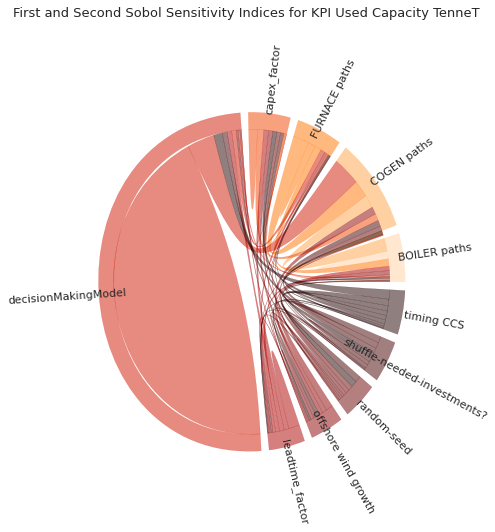

0 11.962647420677328 5.981323710338664
14.962647420677328 48.23439807807249 31.598522749374908
51.23439807807249 109.24234818848839 80.23837313328045
112.24234818848839 124.17225973218477 118.20730396033659
127.17225973218477 252.86696754319274 190.01961363768876
255.86696754319274 271.69007762315374 263.77852258317324
274.69007762315374 291.56981625175484 283.1299469374543
294.56981625175484 311.6446189007806 303.1072175762677
314.6446189007806 330.2033131392849 322.4239660200327
333.2033131392849 357.0 345.10165656964244


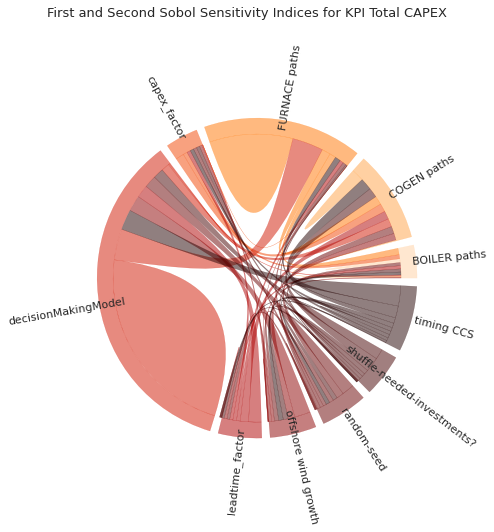

In [ ]:
for ooi in kpi_over_time:
  sobol_stats, s2, s2_conf = get_sobol_scores(ooi)
  s2 = abs(s2)
  #s2 = s2[sobol_stats['ST']>0]
  s2 = s2[s2.index]
  nodes = list(s2.columns)
  s2 = np.array(s2)
  s2[np.tril_indices_from(s2, k=-1)] = s2.transpose()[np.tril_indices_from(s2, k=-1)]
  s2 = pd.DataFrame(s2, columns = nodes, index=nodes)
  for unc in nodes:
      s2.loc[unc][unc] = sobol_stats['S1'][unc]
  s2 = np.array(s2)
  
  fig, ax = plt.subplots(figsize=(7, 7))
  fig.suptitle(f"First and Second Sobol Sensitivity Indices for KPI {kpi_dict[ooi][2]}", size=13, y=1.05 )

  nodePos = chordDiagram(s2, ax, pad=3, colors=sns.color_palette(cmap_r, len(nodes)))
  ax.axis('off')
  prop = dict(fontsize=11, ha='center', va='center')

  for i in range(len(nodes)):
    if nodePos[i][2] < 0:
      ax.text(nodePos[i][0]*1.1, nodePos[i][1]*1.1, nodes[i], rotation=nodePos[i][2]+90, **prop)
    else:
      ax.text(nodePos[i][0]*1.1, nodePos[i][1]*1.1, nodes[i], rotation=nodePos[i][2]-90, **prop)
  fig.tight_layout()
  plt.show()
  save_fig(fig, name=f'chord diagram first and second SI for {ooi}')

In [ ]:

%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2
        # TODO:: remove nans

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0, type='kpi'):
    '''plot sobol indices on a radial plot

    Parameters
    ----------
    sobol_indices : dict
                    the return from SAlib
    criterion : {'ST', 'S1', 'S2', 'ST_conf', 'S1_conf', 'S2_conf'}, optional
    threshold : float
                only visualize variables with criterion larger than cutoff

    '''
    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = get_max_si_s2()[0]
    smin = 0#sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = get_max_si_s2()[1]
    s2min = 0

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)
    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    if type=='kpi':
        ax.set_title(f"Sobol Sensitivity Indices for KPI {kpi_dict[ooi][2]}", size=13)
    else:
        ax.set_title(f"Sobol Sensitivity Indices for {cat} Investments", size=13)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, colors[0], 'black', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, colors[1], 'black', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c=colors[0], lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color=colors[0], fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color=colors[1], fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color=colors[0])]
    ax.legend(some_identifiers, ['Total-order Sensitivity Index',
                                 'First-order Sensitivity Index',
                                 'Second-order Sensitivity Index'],
              loc=(1.1,0.75), borderaxespad=0.1,# mode='expand',
              handler_map={plt.Circle: HandlerCircle()})

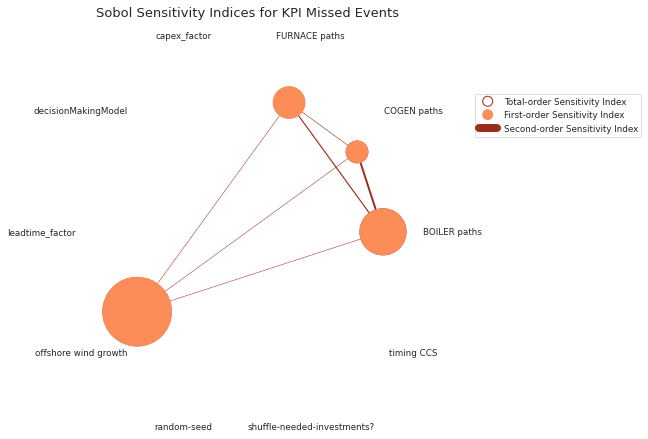

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


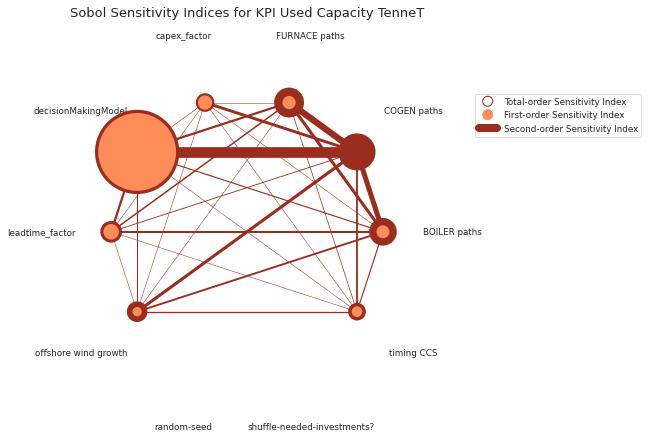

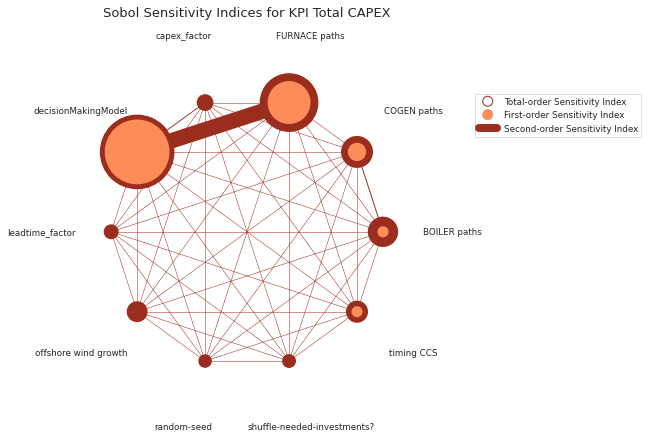

In [ ]:
for ooi in kpi_over_time:
    outcome = outcomes_mean_kpi_over_time[ooi][:,-1]
    Si = sobol.analyze(problem, outcome, calc_second_order=True, print_to_console=False)
    
    fig = plot_sobol_indices(Si, criterion='ST', threshold=0.01)
    fig.set_size_inches(7,7)
    plt.show()
    save_fig(fig, name=f'pairwise interaction total first and second SI for {ooi}')

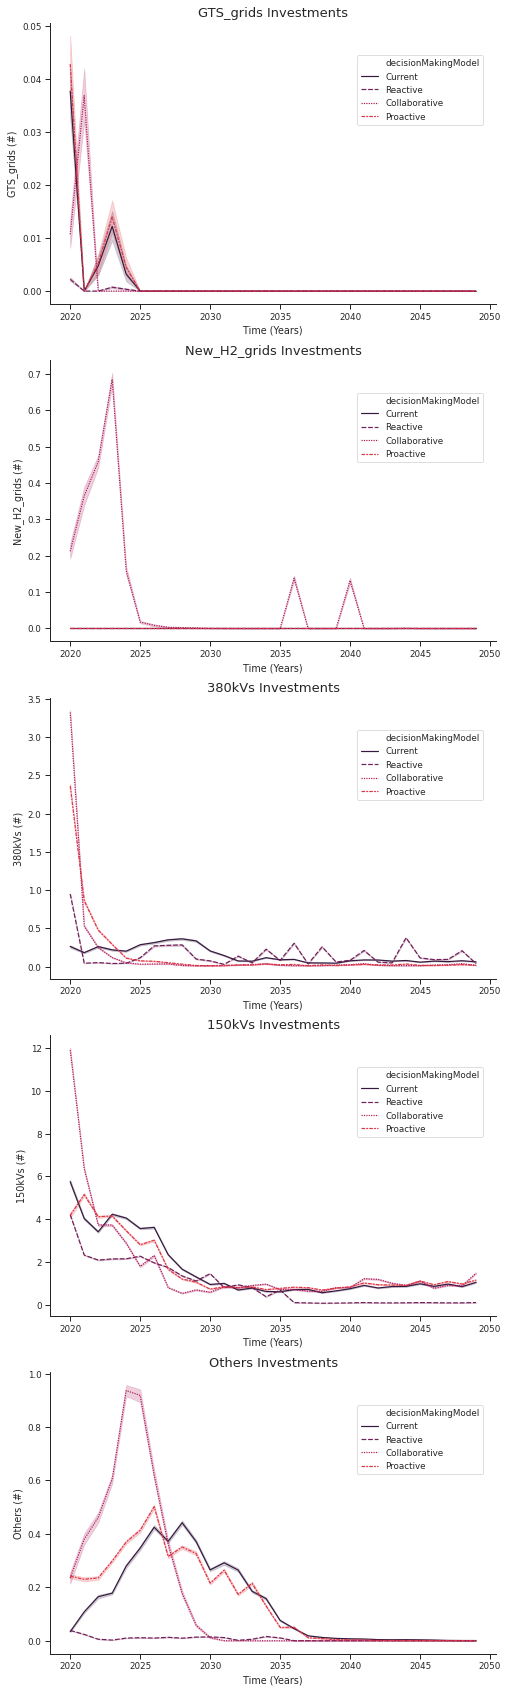

In [ ]:
fig, axes = plt.subplots(len(investment_cats), figsize=(8, 30))
for ax, cat in enumerate(investment_cats):
  axes[ax] = sns.lineplot(data = investments_longform[cat],
                    x = 'year',
                    y=cat,
                    hue='decisionMakingModel',
                    style='decisionMakingModel',
                    ax=axes[ax])
  axes[ax].set_title(f'{cat} Investments', size=13)
  axes[ax].set_xlabel("Time (Years)")
  axes[ax].set_ylabel(f"{cat} (#)")
  axes[ax].legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False)
  sns.despine()

plt.show()
# save_fig(fig, name='lineplots_cumulative_KPI_grouped_by_DM')

In [ ]:
def get_sobol_scores_investments(cat):
    '''analyze results using SALib sobol, returns a dataframe
    '''
    sobol_indices = sobol.analyze(problem, np.asarray(investments_over_time[cat][2049]))
    sobol_stats = {key: sobol_indices[key] for key in ['ST', 'ST_conf', 'S1',
                                                       'S1_conf']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])
    sobol_stats.sort_values(by='ST', ascending=False)
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2_conf = pd.DataFrame(sobol_indices['S2_conf'], index=problem['names'],
                           columns=problem['names'])

    return sobol_stats, s2, s2_conf

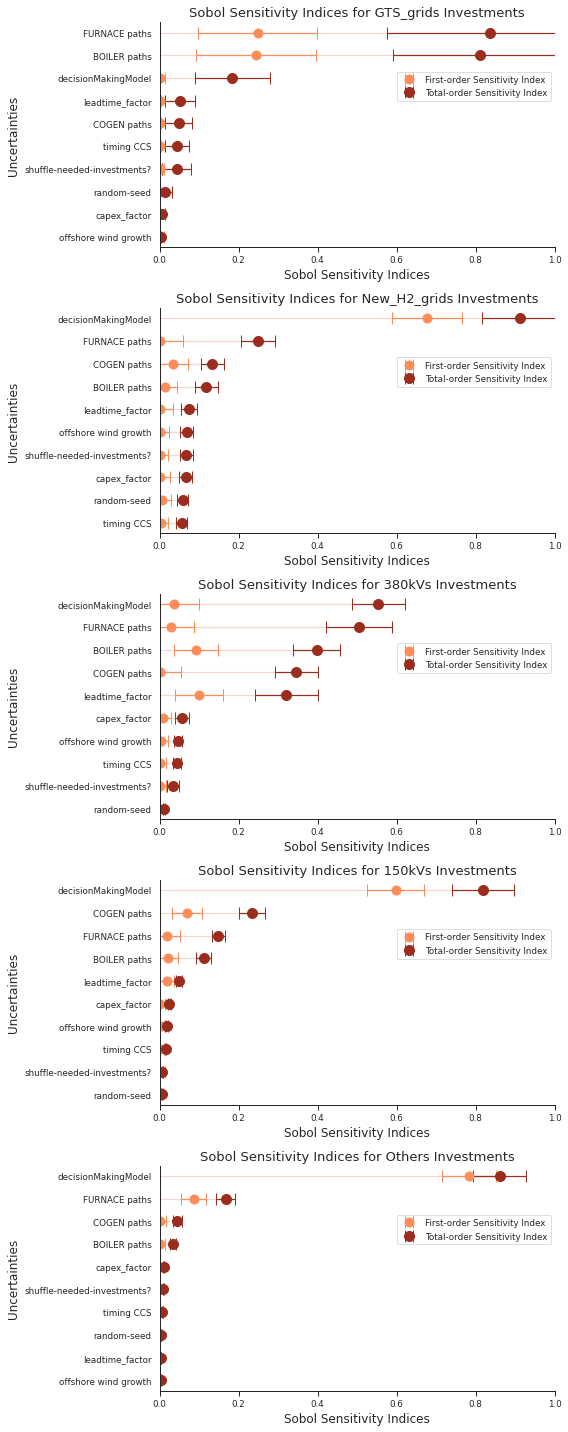

In [ ]:
with sns.axes_style("ticks", {"ytick.left": False}):
  fig, axes = plt.subplots(len(investment_cats),1, figsize=(8,20), sharex=False)
for axnr, cat in enumerate(investment_cats):
  sobol_stats, _, _ = get_sobol_scores_investments(cat)
  sobol_stats = sobol_stats.sort_values(by='ST', ascending=True)
  sobol_stats[sobol_stats<0]=0

  height=range(1,len(sobol_stats.index)+1)
  axes[axnr].hlines(y=height, xmin=0, xmax=sobol_stats['ST'],
                     color=colors[2], alpha=0.2)
  axes[axnr].errorbar(x=sobol_stats['S1'],
                      y = height,
                      xerr = sobol_stats['S1_conf'],
                      color=colors[1],
                      alpha=1, label='First-order Sensitivity Index', fmt='o',
                      ms=9,
                      capsize = 6)
  axes[axnr].errorbar(x=sobol_stats['ST'],
                      y = height,
                      xerr = sobol_stats['ST_conf'],
                      color=colors[0],
                      alpha=1, label='Total-order Sensitivity Index', fmt='o',
                      ms=10,
                      capsize = 6)
  axes[axnr].legend(loc=(0.6,0.65))
  axes[axnr].set_yticks(height)
  axes[axnr].set_yticklabels(sobol_stats.index)
  axes[axnr].set_xlim(0,1)
  axes[axnr].set_xlabel("Sobol Sensitivity Indices", size=12)
  axes[axnr].set_ylabel("Uncertainties", size=12)
  axes[axnr].set_title(f"Sobol Sensitivity Indices for {cat} Investments",
                       size=13)
fig.tight_layout()
sns.despine()
plt.show()
save_fig(fig, name='total_first_order sobol sensitivity indices_investments')

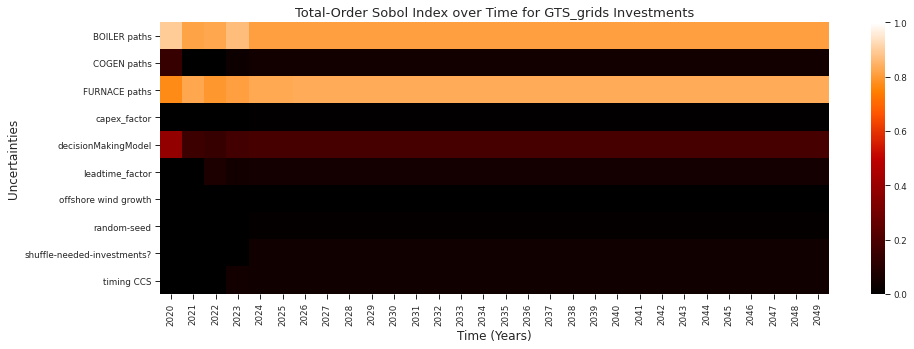

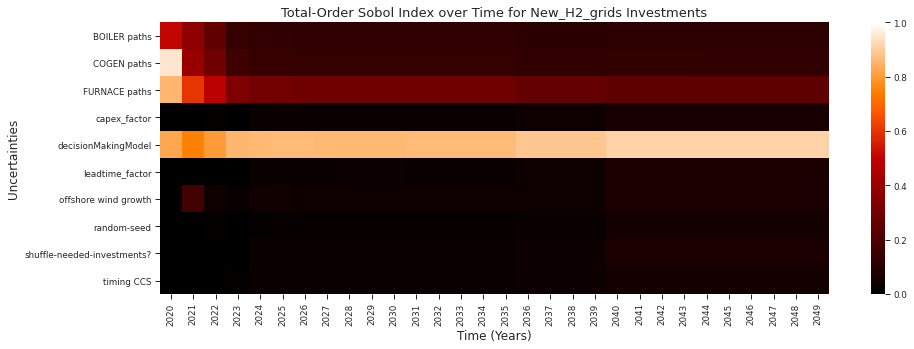

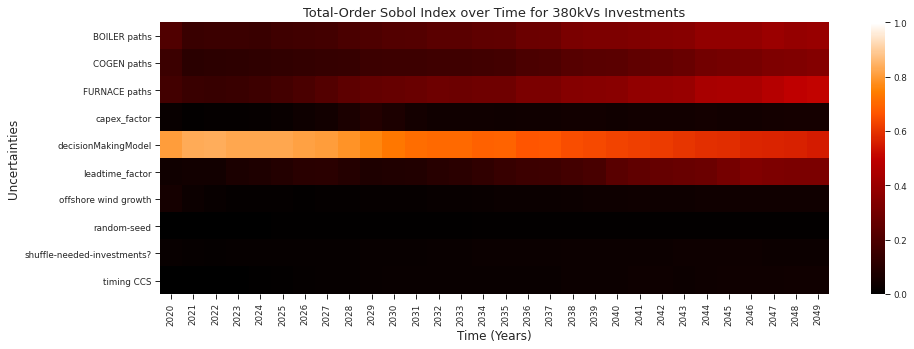

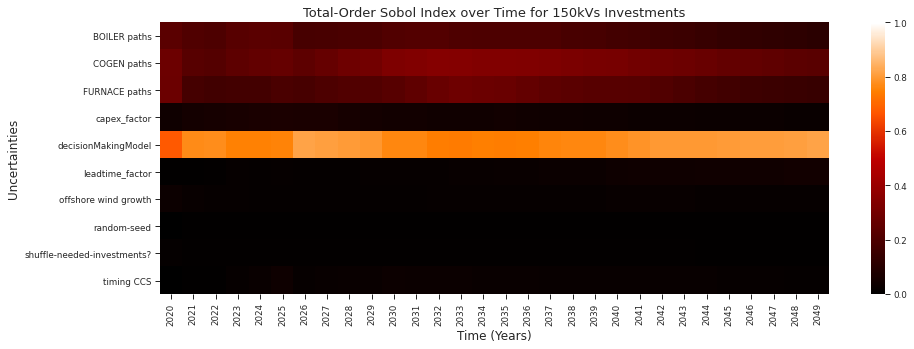

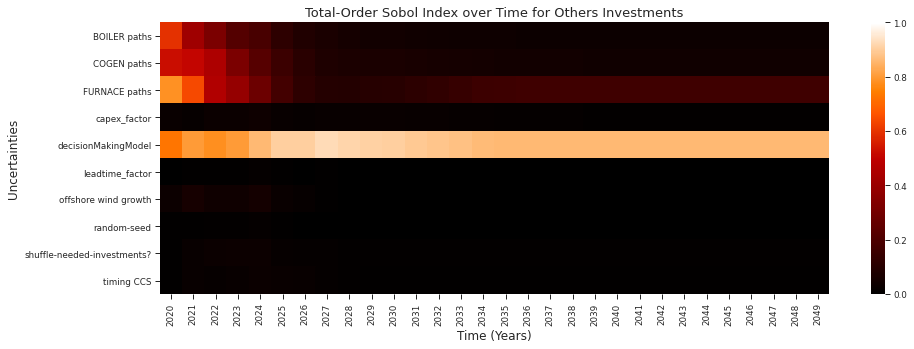

In [ ]:
for cat in investment_cats:
  all_sts = []
  for year in range(2020,2050, 1):
    st = sobol.analyze(problem, np.asarray(investments_over_time[cat][year]))['ST']
    all_sts.append(st)
  all_sts = pd.DataFrame(all_sts).T
  all_sts.columns = np.arange(2020, 2050, 1)
  all_sts.index = problem['names']
  fig, ax = plt.subplots(figsize=(15, 5))
  ax = sns.heatmap(all_sts, cmap=cmap, vmin = 0, vmax = 1, annot = False)
  ax.set_title(f'Total-Order Sobol Index over Time for {cat} Investments', size = 13)
  ax.set_xlabel("Time (Years)", size=12)
  ax.set_ylabel("Uncertainties", size=12)
  plt.show()
  save_fig(fig, name=f'Total-Order SI over time for {cat}')

In [ ]:
investment_cats

['GTS_grids', 'New_H2_grids', '380kVs', '150kVs', 'Others']

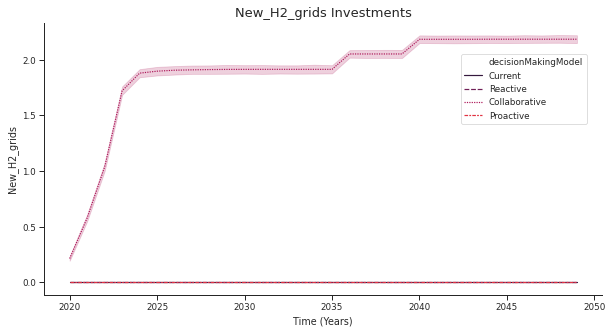

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cat = 'New_H2_grids'
sns.lineplot(data = investments_over_time_longform[cat],
                    x = 'year',
                    y=cat,
                    hue='decisionMakingModel',
                    style='decisionMakingModel',
                    ax=ax)
ax.set_title(f'{cat} Investments', size=13)
ax.set_xlabel("Time (Years)")
ax.legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False)
sns.despine()
plt.show()
save_fig(fig, name=f'lineplots_cumulative_KPI_grouped_by_DM_{cat}')

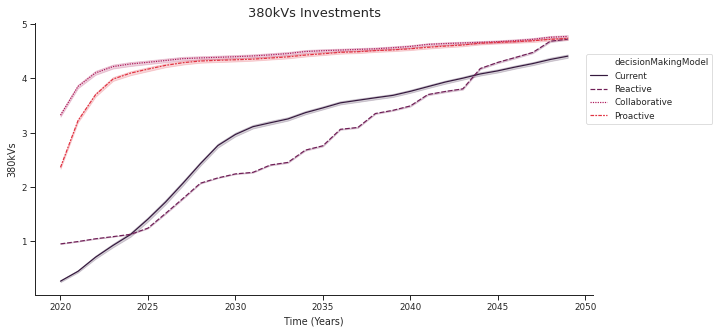

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
cat = '380kVs'
sns.lineplot(data = investments_over_time_longform[cat],
                    x = 'year',
                    y=cat,
                    hue='decisionMakingModel',
                    style='decisionMakingModel',
                    ax=ax)
ax.set_title(f'{cat} Investments', size=13)
ax.set_xlabel("Time (Years)")
ax.legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False)
sns.despine()
plt.show()
save_fig(fig, name=f'lineplots_cumulative_KPI_grouped_by_DM_{cat}')

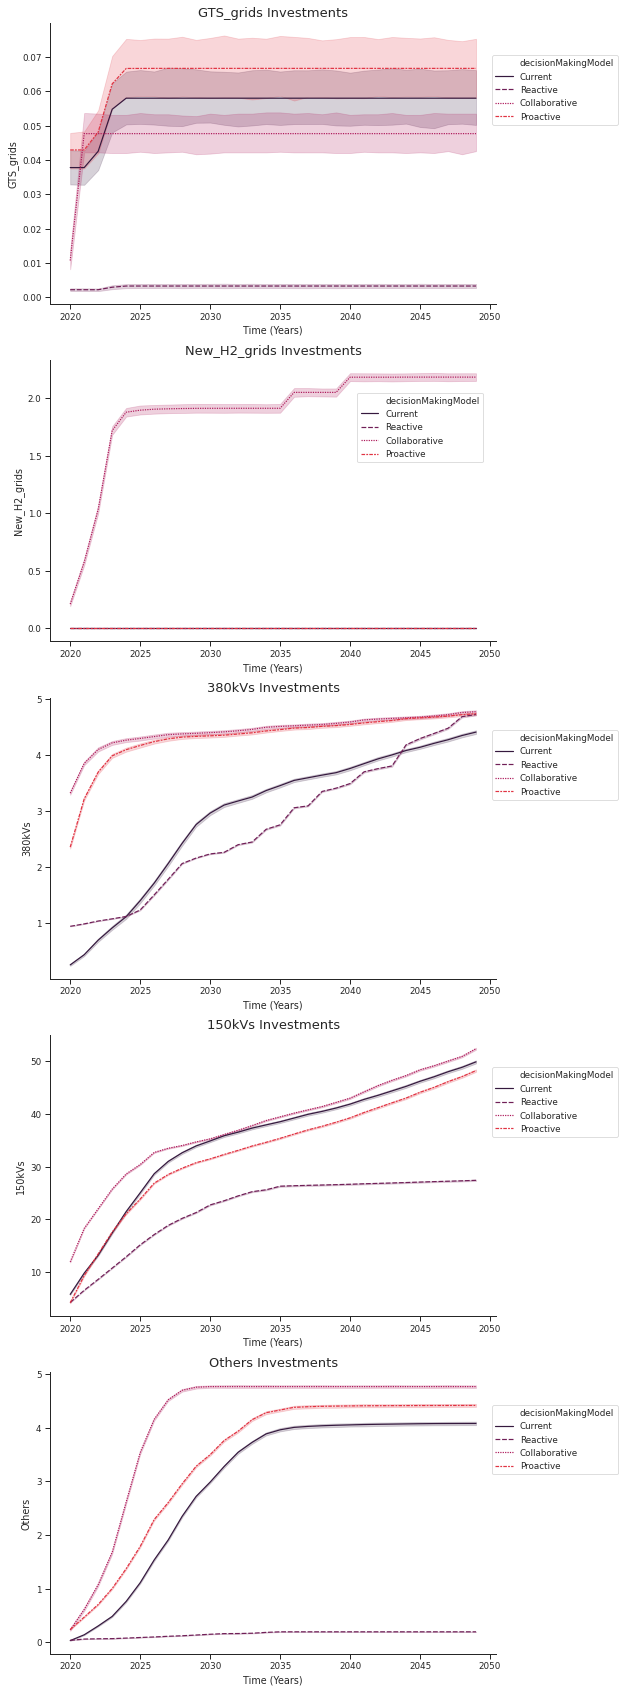

In [ ]:
fig, axes = plt.subplots(len(investment_cats), figsize=(8, 30))
for ax, cat in enumerate(investment_cats):
  axes[ax] = sns.lineplot(data = investments_over_time_longform[cat],
                    x = 'year',
                    y=cat,
                    hue='decisionMakingModel',
                    style='decisionMakingModel',
                    ax=axes[ax])
  axes[ax].set_title(f'{cat} Investments', size=13)
  axes[ax].set_xlabel("Time (Years)")
  axes[ax].legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False)
  sns.despine()

plt.show()
# save_fig(fig, name='lineplots_cumulative_KPI_grouped_by_DM')

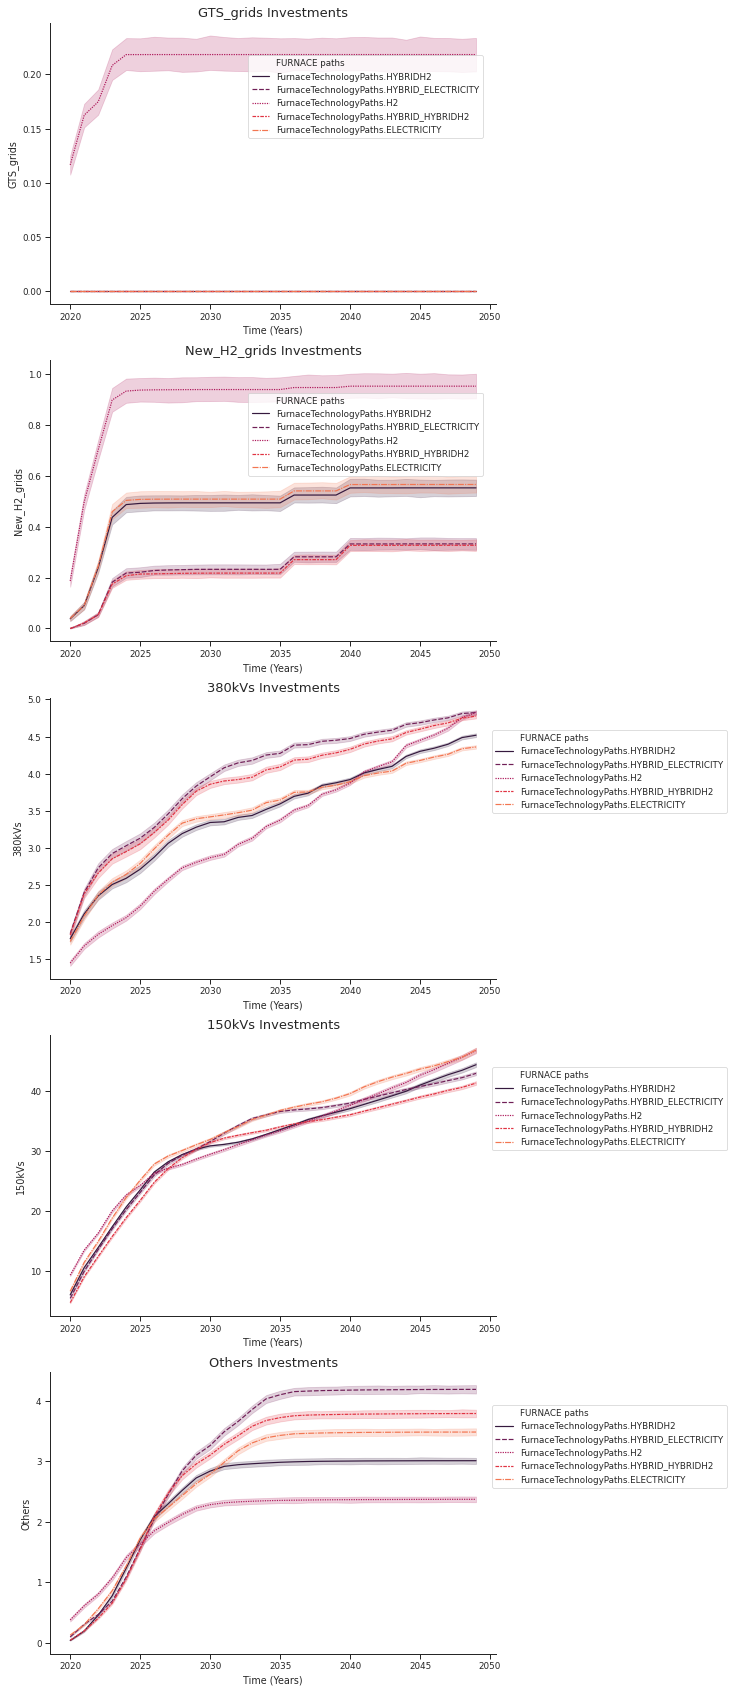

In [ ]:
fig, axes = plt.subplots(len(investment_cats), figsize=(8, 30))
for ax, cat in enumerate(investment_cats):
  axes[ax] = sns.lineplot(data = investments_over_time_longform_furn[cat],
                    x = 'year',
                    y=cat,
                    hue='FURNACE paths',
                    style='FURNACE paths',
                    ax=axes[ax])
  axes[ax].set_title(f'{cat} Investments', size=13)
  axes[ax].set_xlabel("Time (Years)")
  axes[ax].legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False)
  sns.despine()

plt.show()
# save_fig(fig, name='lineplots_cumulative_KPI_grouped_by_DM')

0 95.48079864747116 47.74039932373558
98.48079864747116 108.32630814130663 103.4035533943889
111.32630814130663 204.5672319019774 157.946770021642
207.5672319019774 227.48921105404432 217.52822147801086
230.48921105404432 245.5686710375533 238.0289410457988
248.5686710375533 266.30533588811903 257.4370034628362
269.30533588811903 289.43314663624915 279.3692412621841
292.43314663624915 312.33684527862897 302.38499595743906
315.33684527862897 334.2022014753192 324.7695233769741
337.2022014753192 357.00000000000006 347.10110073765964


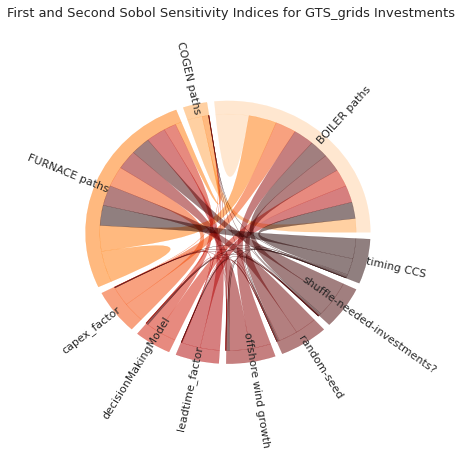

0 9.937419207862995 4.968709603931497
12.937419207862995 55.0838937343067 34.01065647108484
58.0838937343067 95.23398789267264 76.65894081348966
98.23398789267264 114.79780214332145 106.51589501799705
117.79780214332145 239.89404982790404 178.84592598561275
242.89404982790404 261.43456641844284 252.16430812317344
264.43456641844284 285.69474233748093 275.0646543779619
288.69474233748093 314.0104662910387 301.3526043142598
317.0104662910387 336.97608753494956 326.99327691299413
339.97608753494956 356.99999999999994 348.4880437674748


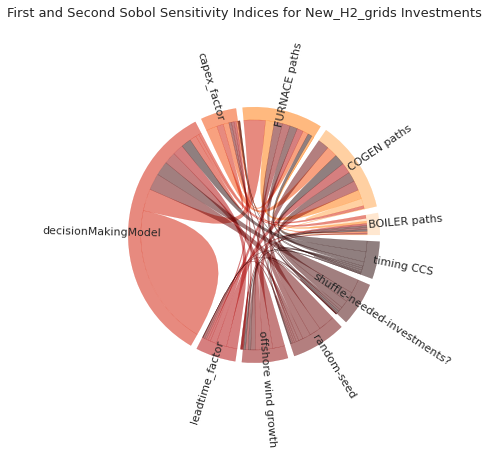

0 58.03652939273735 29.018264696368675
61.03652939273735 80.13899691757197 70.58776315515466
83.13899691757197 141.54711383205483 112.3430553748134
144.54711383205483 164.5422461689961 154.54468000052546
167.5422461689961 221.99702394253637 194.76963505576623
224.99702394253637 269.83839870858174 247.41771132555905
272.83839870858174 295.9735840498682 284.40599137922493
298.9735840498682 315.45905560794245 307.2163198289053
318.45905560794245 333.9221189344626 326.1905872712025
336.9221189344626 357.0 346.9610594672313


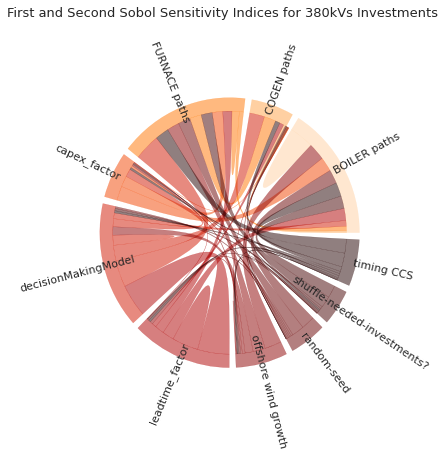

0 19.375467416961506 9.687733708480753
22.375467416961506 67.89442086797023 45.13494414246587
70.89442086797023 99.1781082898664 85.03626457891832
102.1781082898664 115.98074221248967 109.07942525117804
118.98074221248967 270.4386504649776 194.70969633873364
273.4386504649776 284.80227146675145 279.12046096586454
287.80227146675145 300.40481438249793 294.10354292462466
303.40481438249793 319.11435376066936 311.2595840715836
322.11435376066936 338.2012898522171 330.1578218064432
341.2012898522171 357.0 349.10064492610854


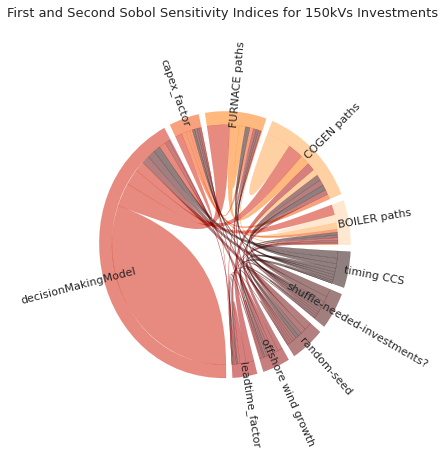

0 10.796679879864223 5.398339939932112
13.796679879864223 25.41134303727294 19.604011458568582
28.41134303727294 67.17201851262644 47.79168077494969
70.17201851262644 79.64269835782194 74.90735843522418
82.64269835782194 298.147815793876 190.39525707584897
301.147815793876 308.7836104674143 304.96571313064516
311.7836104674143 319.1922478596454 315.4879291635299
322.1922478596454 332.4682833964709 327.33026562805816
335.4682833964709 343.55084798627723 339.50956569137406
346.55084798627723 357.0 351.7754239931386


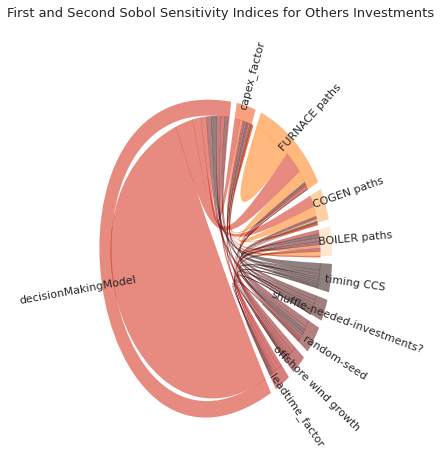

In [ ]:
for cat in investment_cats:
  sobol_stats, s2, s2_conf = get_sobol_scores_investments(cat)
  s2 = abs(s2)
  s2 = s2[sobol_stats['ST']>0]
  s2 = s2[s2.index]
  nodes = list(s2.columns)
  s2 = np.array(s2)
  s2[np.tril_indices_from(s2, k=-1)] = s2.transpose()[np.tril_indices_from(s2, k=-1)]
  s2 = pd.DataFrame(s2, columns = nodes, index=nodes)
  for unc in nodes:
      s2.loc[unc][unc] = sobol_stats['S1'][unc]
  s2 = np.array(s2)
  
  fig, ax = plt.subplots(figsize=(6, 6))
  fig.suptitle(f"First and Second Sobol Sensitivity Indices for {cat} Investments", size=13, y=1.05 )

  nodePos = chordDiagram(s2, ax, pad=3, colors=sns.color_palette(cmap_r, len(nodes)))
  ax.axis('off')
  prop = dict(fontsize=11, ha='center', va='center')

  for i in range(len(nodes)):
    if nodePos[i][2] < 0:
      ax.text(nodePos[i][0]*1.1, nodePos[i][1]*1.1, nodes[i], rotation=nodePos[i][2]+90, **prop)
    else:
      ax.text(nodePos[i][0]*1.1, nodePos[i][1]*1.1, nodes[i], rotation=nodePos[i][2]-90, **prop)
  fig.tight_layout()
  plt.show()
  save_fig(fig, name=f'chord diagram first and second SI for {cat}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


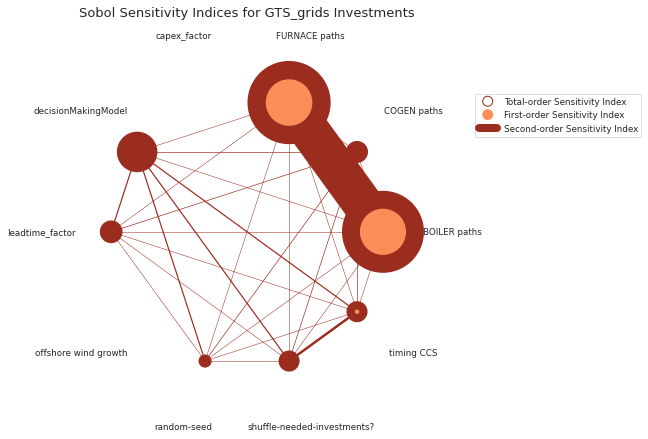

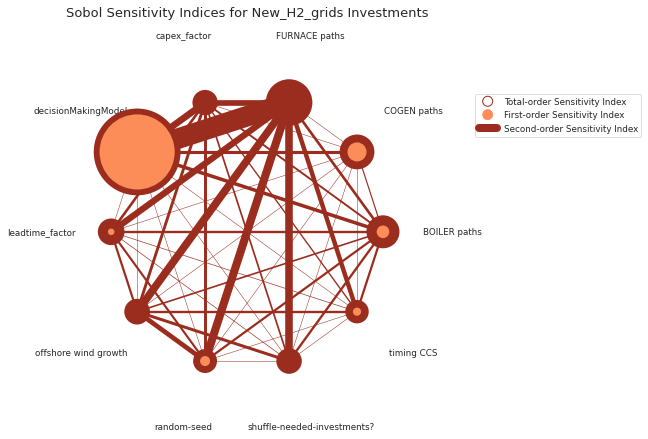

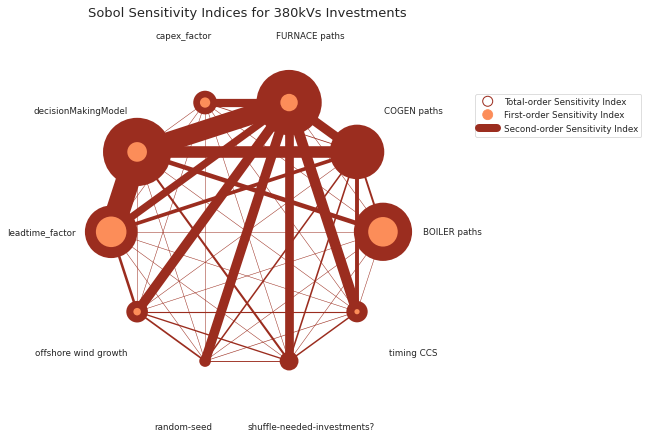

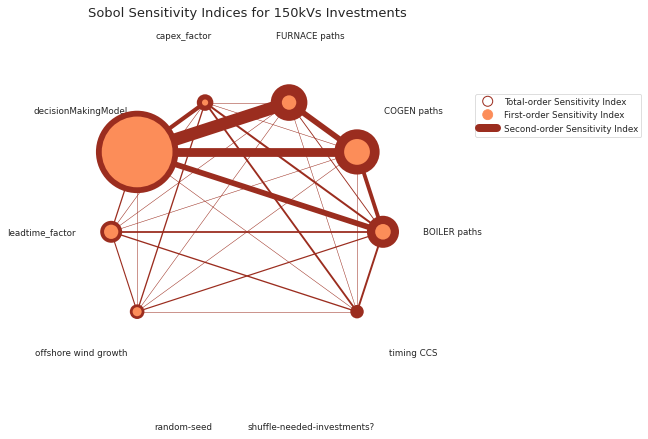

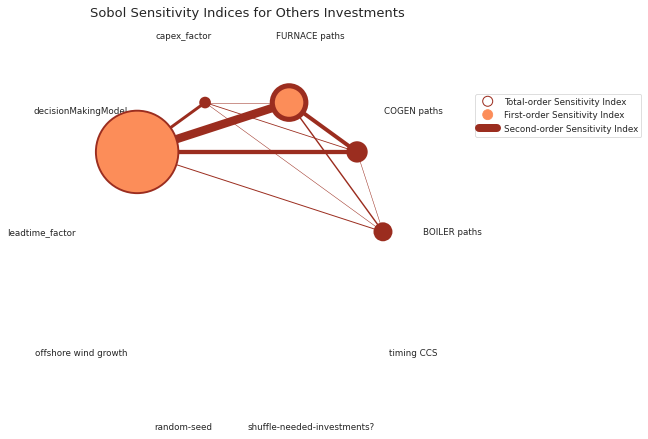

In [ ]:
for cat in investment_cats:
    Si = sobol.analyze(problem, np.asarray(investments_over_time[cat][2049]), calc_second_order=True, print_to_console=False)
    fig = plot_sobol_indices(Si, criterion='ST', threshold=0.01, type='investments')
    fig.set_size_inches(7,7)
    plt.show()
    save_fig(fig, name=f'pairwise interaction total first and second SI for {cat}')

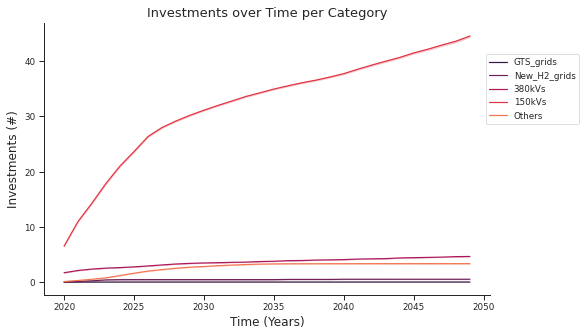

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
for cat in investment_cats:
  ax = sns.lineplot(data = investments_over_time_longform[cat],
                    x = 'year',
                    y=cat,
                    dashes = True,
                    ax=ax)
ax.set_title('Investments over Time per Category', size=13)
ax.set_xlabel("Time (Years)", size=12),
ax.set_ylabel("Investments (#)", size=12)
ax.legend(bbox_to_anchor=(0.98, 0.9), fancybox=True, shadow=False, labels = investment_cats)
sns.despine()

plt.show()
save_fig(fig, name='lineplots_cumulative_investments')